In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%matplotlib inline

In [4]:
import sys
import pathlib

In [5]:
HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd() 

### import the local package 

In [6]:
sys.path.append('../../')

In [59]:
import numpy as np 

In [7]:
from ICU_Water_Watch import plot, utils, GPM, geo

### first step, we update the local GPM-IMERG dataset on disk, which is in by default `/home/nicolasf/operational/ICU/ops/data/GPM_IMERG/daily/extended_SP`

In [8]:
GPM.update(lag=1)

Last downloaded file in /home/nicolasf/operational/ICU/ops/data/GPM_IMERG/daily/extended_SP is GPM_IMERG_daily.v06.2021.09.28.nc

trying to download GPM_IMERG_daily.v06.2021.09.29.nc in /home/nicolasf/operational/ICU/ops/data/GPM_IMERG/daily/extended_SP
trying to download GPM_IMERG_daily.v06.2021.09.30.nc in /home/nicolasf/operational/ICU/ops/data/GPM_IMERG/daily/extended_SP

! file size for input file 3B-DAY-L.MS.MRG.3IMERG.20210930-S000000-E235959.V06.nc4 is too small, netcdf file GPM_IMERG_daily.v06.2021.09.30.nc is not yet available to download from https://gpm1.gesdisc.eosdis.nasa.gov/data/GPM_L3/GPM_3IMERGDL.06/2021/09



In [9]:
ndays = 90

In [10]:
dpath_realtime = CWD.parents[5] / 'ops/data/GPM_IMERG/daily/extended_SP'

In [13]:
lfiles = GPM.get_files_list(dpath = dpath_realtime, ndays=ndays, lag=2)

In [14]:
dset = GPM.make_dataset(lfiles, ndays=ndays)

In [15]:
dset.dims

Frozen({'time': 90, 'lat': 300, 'lon': 460})

In [16]:
dset.data_vars

Data variables:
    precipitationCal  (time, lat, lon) float64 dask.array<chunksize=(1, 300, 460), meta=np.ndarray>

### get the last date and the number of days in the dataset, which are created automatically as global attributes in the dataset 

In [17]:
last_date, ndays_dset  = GPM.get_attrs(dset)

In [18]:
last_date

datetime.datetime(2021, 9, 29, 0, 0)

In [19]:
ndays_dset

90

### extract a "virtual station" from the dataset 

#### we choose Honiara (Solomon Islands) as an example 

In [20]:
station_name = 'Honiara'
lon = 159.9729
lat = -9.4456

#### the function also returns the extracted coordinates, and the distance to the actual coordinates passed, in km 

In [21]:
df, extracted_coords, dist = GPM.get_virtual_station(dset, lat=lat, lon=lon)

In [22]:
df.head()

,observed
2021-07-02,0.508536
2021-07-03,0.191081
2021-07-04,0.638952
2021-07-05,0.068194
2021-07-06,1.277214


In [23]:
extracted_coords

(159.875, -9.375)

In [24]:
dist

13.151756515016995

#### we now extract the daily climatology (default file name is `daily_climatology_5days_rm_2001_2020.nc`, calculated in `notebooks/GPM/calculates_GPM-IMERG_daily_climatologies.ipynb`)

In [25]:
dpath_climatology = CWD.parents[5] / 'ops/data/GPM_IMERG/daily/extended_SP/CLIMATOLOGY'

In [26]:
clim = GPM.get_virtual_station_climatology(dpath=dpath_climatology, lat=lat, lon=lon)

In [27]:
df = GPM.join_clim(df, clim)

In [28]:
df.head()

,observed,climatology
2021-07-02,0.508536,9.933022
2021-07-03,0.191081,9.602021
2021-07-04,0.638952,9.677235
2021-07-05,0.068194,7.618658
2021-07-06,1.277214,6.337031


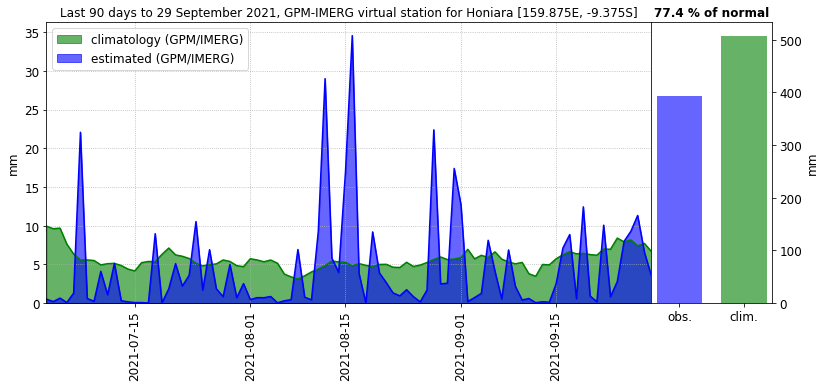

In [29]:
f = plot.plot_virtual_station(df, station_name=station_name, lon=extracted_coords[0], lat=extracted_coords[-1])

### calculate the rainfall accumulation over the past N days 

In [30]:
dset_accum = GPM.calculate_realtime_accumulation(dset)

In [31]:
dset_accum.dims

Frozen({'lat': 300, 'lon': 460, 'time': 1})

In [32]:
dset_accum.data_vars

Data variables:
    precipitationCal  (time, lat, lon) float64 312.0 313.0 310.8 ... 10.54 18.33

### get the rain days stats: number of rain days (threshold = 1 mm/day), number of dry days, and number of days since last rain

In [33]:
dset_ndays = GPM.get_rain_days_stats(dset)

In [34]:
dset_ndays.dims

Frozen({'lat': 300, 'lon': 460, 'time': 1})

In [35]:
dset_ndays.data_vars

Data variables:
    wet_days         (time, lat, lon) float64 dask.array<chunksize=(1, 300, 460), meta=np.ndarray>
    dry_days         (time, lat, lon) float64 dask.array<chunksize=(1, 300, 460), meta=np.ndarray>
    days_since_rain  (time, lat, lon) float64 dask.array<chunksize=(1, 300, 460), meta=np.ndarray>

### get the climatology, for the calculation of the anomalies 

In [36]:
clim = GPM.get_climatology(dpath=dpath_realtime, ndays=ndays, date=last_date)

### calculates the anomalies and the percentages of scores, and insert the resulting variables (`anoms` and `pctscore`) in the dataset 

In [37]:
dset_accum = GPM.calc_anoms_and_pctscores(dset_accum, clim)

In [38]:
dset_accum.dims

Frozen({'time': 1, 'lat': 300, 'lon': 460})

In [39]:
dset_accum.data_vars

Data variables:
    precipitationCal  (time, lat, lon) float64 312.0 313.0 310.8 ... 10.54 18.33
    pctscore          (time, lat, lon) float64 40.0 43.0 45.0 ... 15.0 15.0 33.0
    anoms             (time, lat, lon) float64 -10.34 -9.472 ... -27.4 -20.18

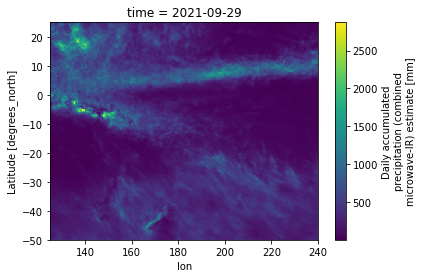

In [41]:
dset_accum['precipitationCal'].squeeze().plot()

In [73]:
thresholds = [-50, 50, 100, 250, 500, 750, 1000, 1250]

In [74]:
hexes= ['#01665e', 
'#5ab4ac',
'#c7eae5',
'#FFFFFF',
'#f6e8c3',
'#d8b365',
'#8c510a']

In [75]:
hexes.reverse()

In [76]:
hexes

['#8c510a', '#d8b365', '#f6e8c3', '#FFFFFF', '#c7eae5', '#5ab4ac', '#01665e']

In [77]:
cbar_ticklabels = ['>1000 mm',
'750 – 1000 mmm',
'500 – 750 mm', 
'250 – 500 mm', 
'100 – 250 mm', 
'50 – 100 mm', 
'< 50 mm']

In [78]:
cbar_ticklabels.reverse()

In [79]:
import matplotlib

In [80]:
ticks_marks = np.diff(np.array(thresholds)) / 2.

ticks = [thresholds[i] + ticks_marks[i] for i in range(len(thresholds) - 1)]

# arguments for the colorbar 

cbar_kwargs={'shrink':0.5, 'pad':0.01, 'extend':'neither', 'drawedges':True, 'ticks':ticks, 'aspect':15}

cmap = matplotlib.colors.ListedColormap(hexes, name='accumulations')

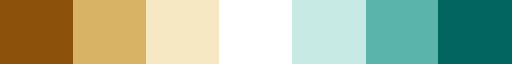

In [81]:
cmap

In [82]:
cmap.set_over('#01665e')

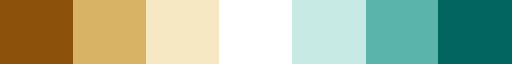

In [83]:
cmap

In [84]:
dataarray = dset_accum['precipitationCal'].squeeze()

In [85]:
from matplotlib import pyplot as plt

In [86]:
from cartopy import crs as ccrs

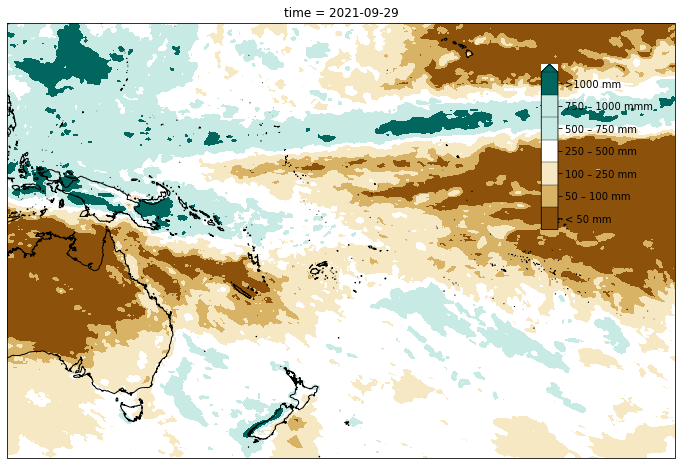

In [87]:
f, ax = plt.subplots(figsize=(13, 8), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})

im = dataarray.plot.contourf(ax=ax, levels=thresholds, cmap=cmap, transform=ccrs.PlateCarree(), add_colorbar=False)

# adds the colorbar axes as insets 

cbar_ax = ax.axes.inset_axes([0.80, 0.525, 0.025, 0.38])

# plots the colorbar in these axes 

cb = plt.colorbar(im, cax=cbar_ax, **cbar_kwargs)

# removes the minor ticks 

cb.ax.minorticks_off() 

# plots the ticklabels 

cbar_ax.set_yticklabels(cbar_ticklabels)

ax.coastlines(resolution='10m')


In [ ]:
hexes = ['']

### get the EEZs for each country, and a dissolved version for the mask 

In [ ]:
EEZs, merged_EEZs = geo.get_EEZs(dpath_shapes='/home/nicolasf/operational/ICU/development/hotspots/data/shapefiles/')

### insert the mask in each dataset 

In [ ]:
dset_accum = geo.make_mask_from_gpd(dset_accum, merged_EEZs, subset=True, mask_name='EEZ')

In [ ]:
dset_ndays = geo.make_mask_from_gpd(dset_ndays, merged_EEZs, subset=True, mask_name='EEZ')

### Plots the precipitation anomalies 

In [ ]:
plot.map_precip_anoms(dset_accum, mask='EEZ', close=False, geoms=EEZs, fpath='.')

In [ ]:
plot.map_EAR_Watch_Pacific(dset_accum, mask='EEZ', geoms=EEZs, close=False, fpath='.')

In [ ]:
plot.map_USDM_Pacific(dset_accum, mask='EEZ', geoms=EEZs, close=False, fpath='.')

In [ ]:
plot.map_decile(dset_accum, mask='EEZ', geoms=EEZs, close=False, fpath='.')

### creates on dataset per country, including the EEZ mask, which then could be exported if needed 

In [ ]:
for i, country_name in enumerate(EEZs.COUNTRYNAM): 
    c = EEZs.query(f"COUNTRYNAM == '{country_name}'")
    sub = geo.make_mask_from_gpd(dset_accum, c, mask_name='mask_EEZ')

In [ ]:
country_name

In [ ]:
(sub['anoms'] * sub['mask_EEZ']).squeeze().plot()